Used Langchain, LangGraph, Claude Sonnet 3.5 LLM, Amazon Bedrock, SQL, SQL Chains to build a question and answering system over SQL data using the langchain documentation.

[Langchain Q&A with SQL](https://python.langchain.com/docs/tutorials/sql_qa/)

At a high-level, the steps of these systems are:


1. Convert question to SQL query: Model converts user input to a SQL query.  
2. Execute SQL query: Execute the query.
3. Answer the question: Model responds to user input using the query results.




Let's install the required packages and put in the AWS credentials.

In [1]:
%%capture --no-stderr

In [13]:
%pip install --upgrade --quiet langchain-community langgraph langchain-aws

I will be using a SQLite connection with the Chinook database, which is a sample database that represents a digital media store.

In [8]:
!apt-get install sqlite3
!curl -s https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite.sql | sqlite3 Chinook.db

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  sqlite3-doc
The following NEW packages will be installed:
  sqlite3
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 769 kB of archives.
After this operation, 1,873 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 sqlite3 amd64 3.37.2-2ubuntu0.4 [769 kB]
Fetched 769 kB in 1s (832 kB/s)
Selecting previously unselected package sqlite3.
(Reading database ... 126109 files and directories currently installed.)
Preparing to unpack .../sqlite3_3.37.2-2ubuntu0.4_amd64.deb ...
Unpacking sqlite3 (3.37.2-2ubuntu0.4) ...
Setting up sqlite3 (3.37.2-2ubuntu0.4) ...
Processing triggers for man-db (2.10.2-1) ...


Now, Chinook.db is in our directory and we can interface with it using the SQLAlchemy-driven SQLDatabase class:

In [9]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

Great! We've got a SQL database that we can query. Now let's try connecting it to an LLM.

Chains are compositions of predictable steps. Let's create a sequence of steps that, given a question, does the following:


*  converts the question into a SQL query
*  executes the query
*  uses the result to answer the original question.

There are scenarios not supported by this arrangement. For example, this system will execute a SQL query for any user input-- even "hello". Importantly, as we'll see below, some questions require more than one query to answer.

The LangGraph state of our application controls what data is input to the application, transferred between steps, and output by the application. It is typically a TypedDict, but can also be a Pydantic BaseModel.

For this application, we can just keep track of the input question, generated query, query result, and generated answer:

In [10]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

The first step is to take the user input and convert it to a SQL query. To reliably obtain SQL queries, we will make use of LangChain's structured output abstraction.

In [14]:
# Ensure your AWS credentials are configured

from langchain.chat_models import init_chat_model

llm = init_chat_model("anthropic.claude-3-5-sonnet-20240620-v1:0", model_provider="bedrock_converse")

Let's provide some instructions for our model:

In [15]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


The prompt includes several parameters we will need to populate, such as the SQL dialect and table schemas. LangChain's SQLDatabase object includes methods to help with this. Our write_query step will just populate these parameters and prompt a model to generate the SQL query:

In [22]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )

    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

Let's test it out:

In [23]:
write_query({"question": "How many Employees are there?"})

{'query': 'SELECT COUNT(*) AS EmployeeCount FROM Employee;'}

This is the most dangerous part of creating a SQL chain. Consider carefully if it is OK to run automated queries over your data. Minimize the database connection permissions as much as possible. Consider adding a human approval step to you chains before query execution (see below).

To execute the query, I will load a tool from langchain-community. The execute_query node will just wrap this tool:

In [24]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

Let's test this step:

In [25]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})

{'result': '[(8,)]'}

Finally, the last step generates an answer to the question given the information pulled from the database:

In [26]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

Finally, I will compile my application into a single graph object. In this case, I am connecting all three steps into a single sequence.

In [27]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

LangGraph also comes with built-in utilities for visualizing the control flow of your application:

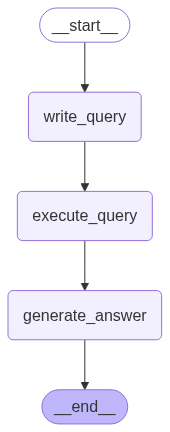

In [28]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Let's test our application!

In [29]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) AS employee_count FROM Employee'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'Based on the SQL query result, the answer to the user\'s question "How many employees are there?" is:\n\nThere are 8 employees.\n\nThe SQL query counted all the rows in the Employee table, and the result shows a single count of 8, indicating that there are 8 employees in total.'}}


LangGraph supports a number of features that can be useful for this workflow. One of them is human-in-the-loop: we can interrupt our application before sensitive steps (such as the execution of a SQL query) for human review. This is enabled by LangGraph's persistence layer, which saves run progress to your storage of choice. Below, we specify storage in-memory:

In [30]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}

Let's visualize the memory we saved!

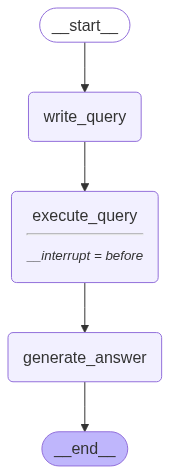

In [31]:
display(Image(graph.get_graph().draw_mermaid_png()))

I didn’t use agents in this notebook, but they can be integrated with LLMs to dynamically make decisions during query execution. While less predictable than chains, agents offer greater adaptability by allowing retries and leveraging both schema and data.